<a href="https://colab.research.google.com/github/plaban1981/Hands_on_unsupervised_learning/blob/master/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

'''Data Prep'''
from sklearn import preprocessing as pp 
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score
from sklearn.metrics import confusion_matrix, classification_report 

'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Data - Credit Card Fraud

In [2]:

df = pd.read_csv('https://media.githubusercontent.com/media/aapatel09/handson-unsupervised-learning/master/datasets/credit_card_data/credit_card.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


##Check for null values

In [3]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

## Data Statistics

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


##Correlation with output label

In [0]:
corr = df[df.columns[1:]].corr()['Class'][:].to_dict()

In [6]:
sorted(corr.items(), key=lambda x:np.abs(x[1]),reverse = True)

[('Class', 1.0),
 ('V17', -0.32648106724269765),
 ('V14', -0.30254369580346246),
 ('V12', -0.2605929248764044),
 ('V10', -0.21688294364035493),
 ('V16', -0.1965389403034051),
 ('V3', -0.19296082706681578),
 ('V7', -0.1872565915137108),
 ('V11', 0.15487564474346413),
 ('V4', 0.1334474862385853),
 ('V18', -0.11148525388869356),
 ('V1', -0.10134729859476972),
 ('V9', -0.09773268607377422),
 ('V5', -0.09497429899115034),
 ('V2', 0.09128865034433538),
 ('V6', -0.04364316069982903),
 ('V21', 0.0404133806104527),
 ('V19', 0.03478301303640623),
 ('V20', 0.020090324196912198),
 ('V8', 0.01987512391473314),
 ('V27', 0.017579728189458178),
 ('V28', 0.009536040916206127),
 ('V24', -0.0072209067159303),
 ('Amount', 0.0056317530067495365),
 ('V13', -0.004569778799447076),
 ('V26', 0.004455397501269385),
 ('V15', -0.004223402267843587),
 ('V25', 0.0033077055972894065),
 ('V23', -0.002685155740242337),
 ('V22', 0.0008053175052959154)]

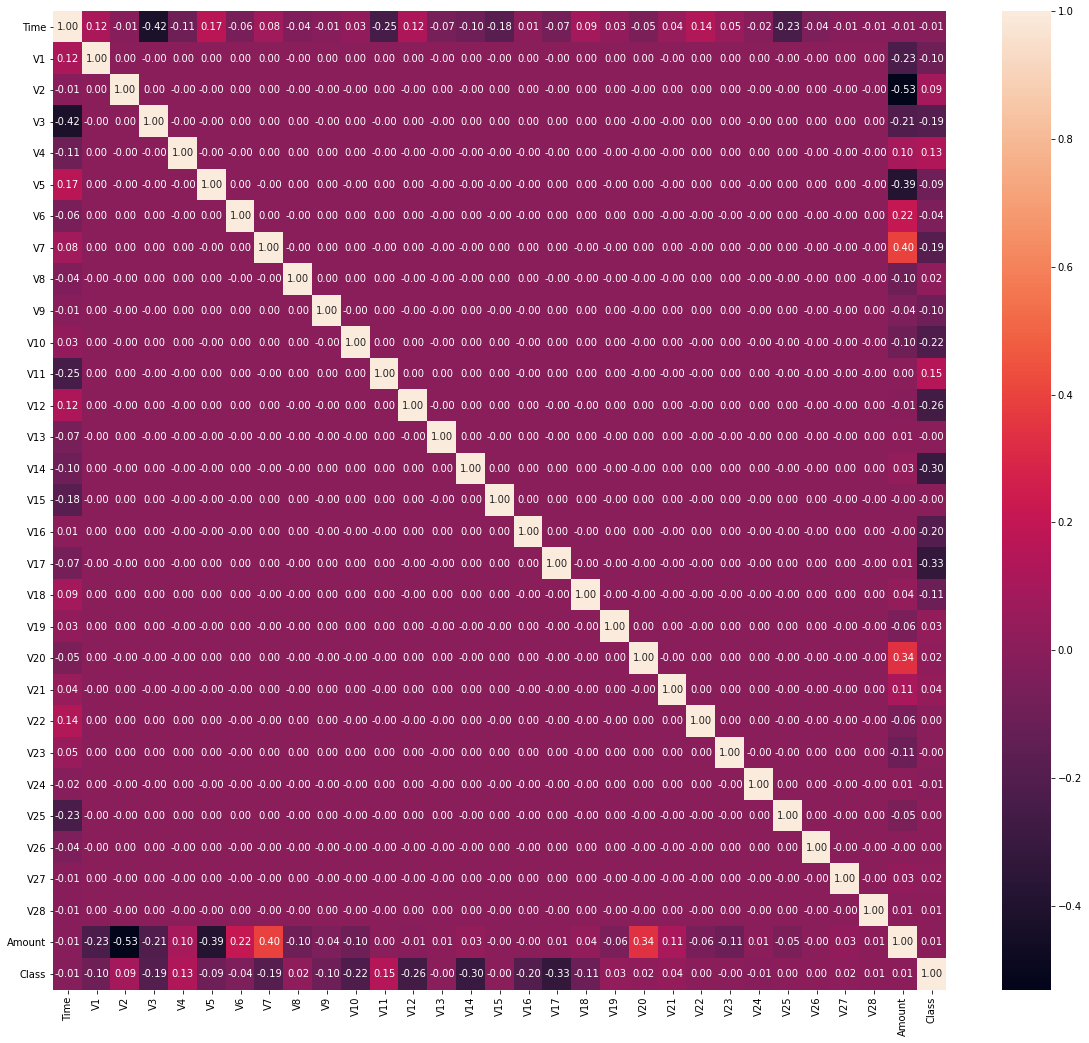

In [7]:
plt.figure(figsize=(20,18))
sns.heatmap(df.corr(),annot=True,fmt=".2f")

In [8]:
df.shape

(284807, 31)

here feature selection is not necessary as the number of observations (284807)vastly outnumbers the number of observations(30 fatures)

# Class Frequency Distribution

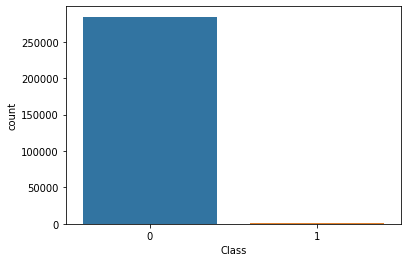

In [9]:
sns.countplot(x='Class',data=df)

The dataset is imbalanced

# Model Preparation

*Generate feature matrix and labels array*

In [0]:

X = df.copy().drop(['Class'],axis=1)
Y = df['Class'].copy()

*Train Test Split*

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33,random_state=2018, stratify=Y)#startified split

In [12]:
print(f'train calss ratio :{y_train.sum()/len(y_train)}')
print(f'test calss ratio :{y_test.sum()/len(y_test)}')

train calss ratio :0.0017293784718582959
test calss ratio :0.0017236426314277506


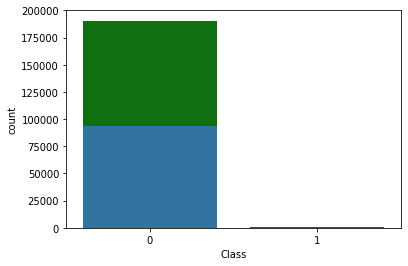

In [13]:
sns.countplot(y_train,color='green')
sns.countplot(y_test)

*Cross Validation*

In [0]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

# Logistic Regression

*Handling Imbalance Data :*

*By default, the errors for each class may be considered to have the same weighting, say 1.0. These weightings can be adjusted based on the importance of each class.*

**minimize sum i to n -(w0 * log(yhat_i) * y_i + w1 * log(1 – yhat_i) * (1 – y_i))**


*The weighting is applied to the loss so that smaller weight values result in a smaller error value, and in turn, less update to the model coefficients. A larger weight value results in a larger error calculation, and in turn, more update to the model coefficients.*

* Small Weight: Less importance, less update to the model coefficients.
* Large Weight: More importance, more update to the model coefficients. 


As such, the modified version of logistic regression is referred to as **Weighted Logistic Regression, Class-Weighted Logistic Regression or Cost-Sensitive Logistic Regression**.

The weightings are sometimes referred to as importance weightings.

Although straightforward to implement, the challenge of weighted logistic regression is the choice of the weighting to use for each class. italicized text 

https://machinelearningmastery.com/cost-sensitive-logistic-regression/

# Weighted Logistic Regression with Scikit-Learn


The scikit-learn Python machine learning library provides an implementation of logistic regression that supports class weighting.

The LogisticRegression class provides the class_weight argument that can be specified as a model hyperparameter. The class_weight is a dictionary that defines each class label (e.g. 0 and 1) and the weighting to apply in the calculation of the negative log likelihood when fitting the model.

The class weighing can be defined multiple ways; for example:

* Domain expertise, determined by talking to subject matter experts.
* Tuning, determined by a hyperparameter search such as a grid search.
* Heuristic, specified using a general best practice.


#### A best practice for using the class weighting is to use the inverse of the class distribution present in the training dataset.

*ratio of minority class to majority class in train and test dataset*

In [15]:
y_train[y_train== 1].count() / y_train[y_train == 0].count()

0.001732374402855793

In [16]:
y_test[y_test== 1].count() / y_test[y_test == 0].count()

0.0017266187050359713

In [0]:
penalty = 'l2'
C = 1.0
class_weight = {0:0.25,1:1}
random_state = 2018
solver = 'liblinear'
n_jobs = 1

logReg = LogisticRegression(penalty=penalty, C=C, 
            class_weight=class_weight, random_state=random_state, 
                            solver=solver, n_jobs=n_jobs)

In [18]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

model = logReg
i = 0
for train_index, cv_index in k_fold.split(X_train,y_train.ravel()):
    i +=1
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:],X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index],y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold,model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    trainCV = accuracy_score(y_train_fold, model.predict(X_train_fold))

    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    accCV = accuracy_score(y_cv_fold, model.predict(X_cv_fold))
    cvScores.append(loglossCV)
    
    print("K Fold :",i)
    print('*'* 80)
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    print('\n')
    print('Training Accuracy: ', trainCV)
    print('CV Accuracy: ', accCV)
    print('\n')
    
loglossLogisticRegression = log_loss(y_train, predictionsBasedOnKFolds.loc[:,1])
print('Logistic Regression Log Loss: ', loglossLogisticRegression)


K Fold : 1
********************************************************************************
Training Log Loss:  0.008145464622250586
CV Log Loss:  0.007908166999687525


Training Accuracy:  0.9992204695524578
CV Accuracy:  0.9991091080599518


K Fold : 2
********************************************************************************
Training Log Loss:  0.006862985669699479
CV Log Loss:  0.005910341339534392


Training Accuracy:  0.9992335709045174
CV Accuracy:  0.9992925269887852


K Fold : 3
********************************************************************************
Training Log Loss:  0.006984663430861408
CV Log Loss:  0.007981254532896238


Training Accuracy:  0.9991811654962792
CV Accuracy:  0.9991353107640708


K Fold : 4
********************************************************************************
Training Log Loss:  0.008327198800192639
CV Log Loss:  0.00816969323305873


Training Accuracy:  0.9992139188764281
CV Accuracy:  0.9992925269887852


K Fold : 5
**************

# ROC Curve

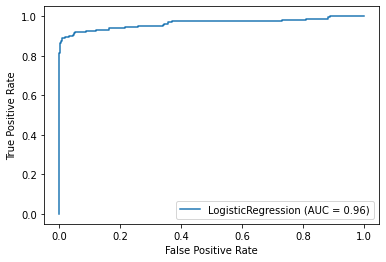

In [19]:
from sklearn.metrics import plot_roc_curve,plot_confusion_matrix
plot_roc_curve(logReg,X_test,y_test)

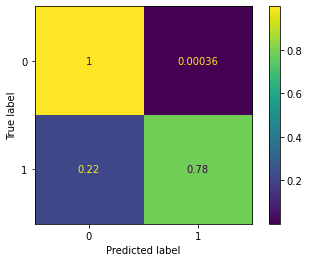

In [20]:
plot_confusion_matrix(logReg,X_test,y_test,normalize='true')

In [21]:
from sklearn.metrics import f1_score
f1_score(y_test,logReg.predict(X_test))

0.7863777089783281

# The scikit-learn library provides an implementation of the best practice heuristic for the class weighting.

It is implemented via the compute_class_weight() function and is calculated as:

**n_samples / (n_classes * n_samples_with_class)**


We can test this calculation manually on our dataset. 


For example, we have 10,000 examples in the dataset, 9900 in class 0, and 100 in class 1.

The weighting for class 0 is calculated as:

weighting = n_samples / (n_classes * n_samples_with_class)

weighting = 10000 / (2 * 9900)

weighting = 10000 / 19800

weighting = 0.05

The weighting for class 1 is calculated as:

weighting = n_samples / (n_classes * n_samples_with_class)

weighting = 10000 / (2 * 100)

weighting = 10000 / 200

weighting = 50

We can confirm these calculations by calling the compute_class_weight() function and specifying the class_weight as “balanced.”



In [22]:
from sklearn.utils.class_weight import compute_class_weight
# calculate class weighting
weighting = compute_class_weight('balanced', [0,1], Y)
print(weighting)

[  0.50086524 289.43800813]


# Grid Search Weighted Logistic Regression

In [0]:
from sklearn.model_selection import GridSearchCV



balance = [{0:0.45,1:1},{0:0.5,1:1}, {0:0.15,1:1}, {0:0.35,1:1}, {0:0.25,1:1}, {0:0.6,1:1}]
param_grid = dict(class_weight=balance)
#
grid = GridSearchCV(estimator= logReg, param_grid=param_grid, n_jobs=-1, cv=5, scoring='f1')

In [24]:
grid.fit(X,Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight={0: 0.25, 1: 1},
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=1, penalty='l2',
                                          random_state=2018, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'class_weight': [{0: 0.45, 1: 1}, {0: 0.5, 1: 1},
                                          {0: 0.15, 1: 1}, {0: 0.35, 1: 1},
                                          {0: 0.25, 1: 1}, {0: 0.6, 1: 1}]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [25]:
print(f'best parameters : {grid.best_params_}')
print(f'best parameters : {grid.best_score_}')

best parameters : {'class_weight': {0: 0.25, 1: 1}}
best parameters : 0.6994267923850955


In [26]:
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.613694 (0.244283) with: {'class_weight': {0: 0.45, 1: 1}}
0.623085 (0.239718) with: {'class_weight': {0: 0.5, 1: 1}}
0.654532 (0.257470) with: {'class_weight': {0: 0.15, 1: 1}}
0.674018 (0.257954) with: {'class_weight': {0: 0.35, 1: 1}}
0.699427 (0.178417) with: {'class_weight': {0: 0.25, 1: 1}}
0.552476 (0.263848) with: {'class_weight': {0: 0.6, 1: 1}}


In [27]:
f1_score(y_test,grid.best_estimator_.predict(X_test))

0.7831325301204819

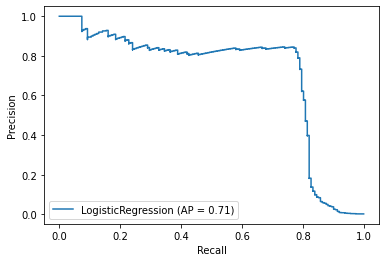

In [48]:
from sklearn.metrics import plot_precision_recall_curve

penalty = 'l2'
C = 1.0
class_weight = {0:0.25,1:1}
random_state = 2018
solver = 'liblinear'
n_jobs = 1

logReg = LogisticRegression(penalty=penalty, C=C, 
            class_weight=class_weight, random_state=random_state, 
                            solver=solver, n_jobs=n_jobs)

logReg.fit(X_train,y_train)
y_pred = logReg.predict(X_test)
plot_precision_recall_curve(logReg,X_test,y_test)

*with weight = 'balanced'*

In [28]:
penalty = 'l2'
C = 1.0
class_weight = 'balanced'
random_state = 2018
solver = 'liblinear'
n_jobs = 1

logReg = LogisticRegression(penalty=penalty, C=C, 
            class_weight=class_weight, random_state=random_state, 
                            solver=solver, n_jobs=n_jobs)



model = logReg
i = 0
for train_index, cv_index in k_fold.split(X_train,y_train.ravel()):
    i +=1
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:],X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index],y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold,model.predict_proba(X_train_fold)[:,1])
    #trainingScores.append(loglossTraining)
    trainCV = accuracy_score(y_train_fold, model.predict(X_train_fold))

    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    accCV = accuracy_score(y_cv_fold, model.predict(X_cv_fold))
    #cvScores.append(loglossCV)
    
    print("K Fold :",i)
    print('*'* 80)
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    print('\n')
    print('Training Accuracy: ', trainCV)
    print('CV Accuracy: ', accCV)
    print('\n')
    


K Fold : 1
********************************************************************************
Training Log Loss:  0.10943413732968182
CV Log Loss:  0.10858633973025444


Training Accuracy:  0.97897888062048
CV Accuracy:  0.9783041609894141


K Fold : 2
********************************************************************************
Training Log Loss:  0.10452743402765072
CV Log Loss:  0.10398720620602298


Training Accuracy:  0.9734370086992977
CV Accuracy:  0.9730636201656011


K Fold : 3
********************************************************************************
Training Log Loss:  0.11558192793972848
CV Log Loss:  0.11799027363286076


Training Accuracy:  0.9745702756524474
CV Accuracy:  0.9755266743527932


K Fold : 4
********************************************************************************
Training Log Loss:  0.11576325315426426
CV Log Loss:  0.11834814977244154


Training Accuracy:  0.9748912587779058
CV Accuracy:  0.9747929986374594


K Fold : 5
***********************

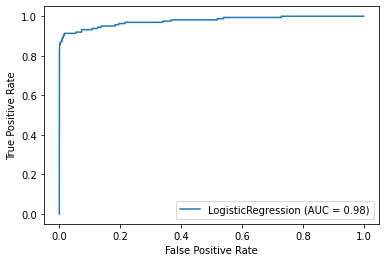

In [29]:
plot_roc_curve(logReg,X_test,y_test)

In [30]:
f1_score(y_test,logReg.predict(X_test))

0.12374581939799333

The F1 Score 

# Apply Oversamplting techniques

In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.


*Random OverSampling*

In [0]:
x = X_train.copy()
x['Class'] = y_train

In [0]:
# Class count
count_class_0, count_class_1 = x['Class'].value_counts()

# Divide by class
df_class_0 = x[x['Class'] == 0]
df_class_1 = x[x['Class'] == 1]

In [33]:
df_class_0.shape,df_class_1.shape

((190490, 31), (330, 31))

*Random over-sampling*

Random over-sampling:
1    190490
0    190490
Name: Class, dtype: int64


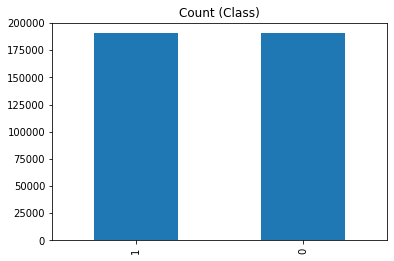

In [34]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Class.value_counts())

df_test_over.Class.value_counts().plot(kind='bar', title='Count (Class)');

In [0]:
X_train = df_test_over.drop('Class',axis=1)
y_train = df_test_over['Class']

In [36]:
penalty = 'l2'
C = 1.0
class_weight = 'balanced'
random_state = 2018
solver = 'liblinear'
n_jobs = 1

logReg = LogisticRegression(penalty=penalty, C=C, 
            class_weight=class_weight, random_state=random_state, 
                            solver=solver, n_jobs=n_jobs)



model = logReg
i = 0
for train_index, cv_index in k_fold.split(X_train,y_train.ravel()):
    i +=1
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:],X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index],y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold,model.predict_proba(X_train_fold)[:,1])
    #trainingScores.append(loglossTraining)
    trainCV = accuracy_score(y_train_fold, model.predict(X_train_fold))
    trainf1 = f1_score(y_train_fold,model.predict(X_train_fold))

    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    accCV = accuracy_score(y_cv_fold, model.predict(X_cv_fold))
    testf1 = f1_score(y_cv_fold,model.predict(X_cv_fold))
    #cvScores.append(loglossCV)
    
    print("K Fold :",i)
    print('*'* 80)
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    print('\n')
    print('Training Accuracy: ', trainCV)
    print('CV Accuracy: ', accCV)
    print('\n')

    print('Training F1 Score : ', trainf1)
    print('CV F1 Score : ', testf1)
    print('\n')

K Fold : 1
********************************************************************************
Training Log Loss:  0.17181559076338546
CV Log Loss:  0.17014770042324898


Training Accuracy:  0.9388419339597879
CV Accuracy:  0.9400230983253715


Training F1 Score :  0.936744514351258
CV F1 Score :  0.9380456591291145


K Fold : 2
********************************************************************************
Training Log Loss:  0.1583618775665272
CV Log Loss:  0.15940322297775203


Training Accuracy:  0.9454958265525749
CV Accuracy:  0.9448921203212767


Training F1 Score :  0.944156839543358
CV F1 Score :  0.9434851074711638


K Fold : 3
********************************************************************************
Training Log Loss:  0.16012230370261646
CV Log Loss:  0.16425901443008162


Training Accuracy:  0.9434714420704499
CV Accuracy:  0.941506115806604


Training F1 Score :  0.9418809012187841
CV F1 Score :  0.939728731963921


K Fold : 4
****************************************

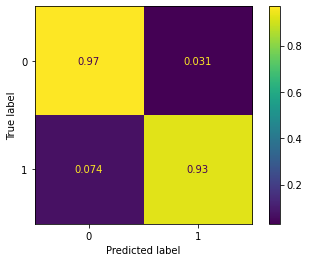

In [37]:
plot_confusion_matrix(logReg,X_test,y_test,normalize='true')

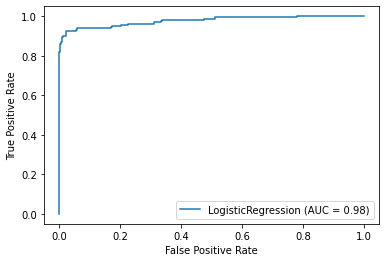

In [38]:
plot_roc_curve(logReg,X_test,y_test)

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test,logReg.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     93825
           1       0.05      0.93      0.09       162

    accuracy                           0.97     93987
   macro avg       0.52      0.95      0.54     93987
weighted avg       1.00      0.97      0.98     93987



# SMOTE

In [40]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(x.drop('Class',axis=1),x['Class'])

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


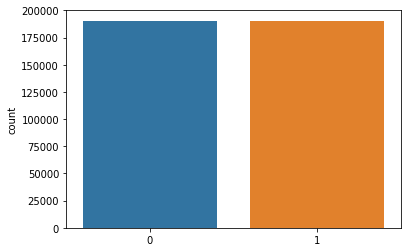

In [41]:
sns.countplot(y_sm)

In [42]:
model = logReg
i = 0
for train_index, cv_index in k_fold.split(X_sm,y_sm):
    i +=1
    X_train_fold, X_cv_fold = X_sm[train_index,:],X_sm[cv_index,:]
    y_train_fold, y_cv_fold = y_sm[train_index],y_sm[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold,model.predict_proba(X_train_fold)[:,1])
    #trainingScores.append(loglossTraining)
    trainCV = accuracy_score(y_train_fold, model.predict(X_train_fold))
    trainf1 = f1_score(y_train_fold,model.predict(X_train_fold))

    y_pred_proba = model.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, y_pred_proba[:,1])
    accCV = accuracy_score(y_cv_fold, model.predict(X_cv_fold))
    testf1 = f1_score(y_cv_fold,model.predict(X_cv_fold))
    #cvScores.append(loglossCV)
    
    print("K Fold :",i)
    print('*'* 80)
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    print('\n')
    print('Training Accuracy: ', trainCV)
    print('CV Accuracy: ', accCV)
    print('\n')

    print('Training F1 Score : ', trainf1)
    print('CV F1 Score : ', testf1)
    print('\n')

K Fold : 1
********************************************************************************
Training Log Loss:  0.10433102047345257
CV Log Loss:  0.10463814257952808


Training Accuracy:  0.9679970077169405
CV Accuracy:  0.9673998635098955


Training F1 Score :  0.9675076783679888
CV F1 Score :  0.9668888296454278


K Fold : 2
********************************************************************************
Training Log Loss:  0.10542429740664859
CV Log Loss:  0.10583470291895128


Training Accuracy:  0.9673539293401229
CV Accuracy:  0.9669273977636621


Training F1 Score :  0.9668271410663324
CV F1 Score :  0.9663892445582587


K Fold : 3
********************************************************************************
Training Log Loss:  0.08546469271333691
CV Log Loss:  0.08486650957411798


Training Accuracy:  0.9711664654312563
CV Accuracy:  0.9718751640506064


Training F1 Score :  0.9708193041526376
CV F1 Score :  0.9715431500391731


K Fold : 4
***********************************

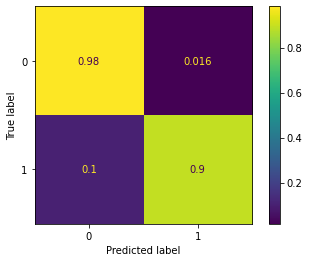

In [43]:
plot_confusion_matrix(logReg,X_test,y_test,normalize='true')

In [44]:
print(classification_report(y_test,logReg.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     93825
           1       0.09      0.90      0.16       162

    accuracy                           0.98     93987
   macro avg       0.54      0.94      0.57     93987
weighted avg       1.00      0.98      0.99     93987



In [45]:
f1_score(y_train,logReg.predict(X_train))

0.9308337934842629

In [46]:
f1_score(y_test,logReg.predict(X_test))

0.15726681127982647

## Smoteing algorithms did not help in increasing the F1 score